# EB Factorization
We compute the unique EB factorization of an inversed TN matrix.
See the book Totally TN matrices, and specifically the factorization in Theorem 2.2.2, for more details.

A matrix $A\in \mathbb R^{n\times n}$ is an Invertibel TN matrix (ITN) if and only if it can be expressed as:
\begin{equation*}
A = L D U,
\end{equation*}
Where
\begin{align*}
L:=&[L_n(\ell_k)\cdots L_2(\ell_{k-n+2})] [L_n(\ell_{k-n+1})\cdots L_3(\ell_{k-2n+4})]\cdots [L_n(\ell_1)],\\
U:=&[U_n(u_1)][U_{n-1}(u_2)U_n(u_3)]\cdots [U_2(u_{k-n+2})\cdots U_n(u_k)],
\end{align*}
$D$ is a diagonal matrix with positive entries, $\ell_i,u_i \ge 0$ for all $i$,
and $k:=\frac{(n-1)n}{2}$.

## TP/TN/OSC/EB Functions

In [1]:
#%%writefile TP_TN_OSC_funcs.py

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb
import networkx as nx
import functools as fnt
from itertools import combinations
'''Implementation here of the EB factorization on an invertible TN matrix
    is based on chapter 2 of the book "Totally Nonnegative Matrices", Fallat & Johnson.'''


def matrix_minor(A, r_indxs, c_indxs):
    '''This function returns the minor of a matrix A with rows indexed by r_indxs and 
    columns by c_indxs. r_indxs and c_indxs are lists (or 1D numpy arrays), and these indexes 
    start from 0 (which is the first row/column index).'''
    return np.linalg.det(A[np.ix_(r_indxs, c_indxs)]) if len(r_indxs)==len(c_indxs) else None

def compute_MC_matrix( A, p ):
    '''This function computes the p'th order multiplicative
    compound matrix of the given matrix A. It returns the MC
    matrix and the lexicography order (with 0 as the first index)'''
    x = np.arange(np.minimum(*A.shape), dtype=int)  # 0, .., n-1, where n:=min(matrix dimensions)
    lp = np.array(list(combinations(x, p))) # lexicography order of the p inxedes in x 
    lp_len = len(lp)
    Q = np.array([matrix_minor(A, lp[r], lp[c]) for r in range(lp_len) for c in range(lp_len)]).reshape(lp_len, lp_len)
    return Q, lp

def E(n, i, j):
    '''Returns the E_{ij} matrix'''
    mat = np.zeros((n,n))
    mat[i-1,j-1] = 1
    return mat

def L(n, i, a):
    '''Returns the L_i(a) matrix'''
    return np.identity(n) + a*E(n, i, i-1)

def U(n, i, a):
    '''Returns the U_i(a) matrix'''
    return np.identity(n) + a*E(n, i-1, i)

def compute_L_factorization( A, abs_thres=0 ):
    '''This function computes the L factorization of a square matrix'''
    n = A.shape[0]
    k = comb(n, 2, exact=True)
    Lmat = []
    vals = []
    Um = A
    for j in range(n-1):
        for i in range(n-1,j,-1):
            val = Um[i,j] / Um[i-1,j] if Um[i-1,j] != 0 else 0
            if np.abs(val) < abs_thres: # < 10*np.finfo(np.float).eps:
                val = 0
            vals.append(val)
            Lmat.append(L(n,i+1, val))
            Um = np.matmul( L(n,i+1, -val), Um )
    return Lmat, Um, np.asarray(vals)

def EB_factorization_ITN( A, abs_thres=0 ):
    '''This function computes the EB factorization of 
    an inversed TN matrix. See Theorem 2.2.2 for more details.
    
    Given an inversed TN matrix A, the following holds:
    
       A = Lmat{1}*Lmat{2}*...*Lmat{end}*Dmat*Umat{end}*Umat{end-1}*...*Umat{1}.
       
     For example, for n=4:
       A = L_4(l_1)*L_3(l_2)*L_2(l_3)*L_4(l_4)*L_3(l_5)*L_4(l_6)*D*
           U_4(u_6)*U_3(u_5)*U_4(u_4)*U_2(u_3)*U_3(u_2)*U_4(l_1),
       
       
    Returned parameters:
    Lmat - a list of the L matrices in the order as in the multiplication. 
           For example, for n=4: [L_4(valsL(1)),L_3(valsL(2)),L_2(valsL(3)),L_4(valsL(4)),L_3(valsL(5)),L_4(valsL(6))].
    Dmat - the diagonal matrix.
    Umat - a list of the U matrices in the REVERSED order of the multiplication.
           For example, for n=4: [U_4(valsU(1)),U_3(valsU(2)),U_2(valsU(3)),U_4(valsU(4)),U_3(valsU(5)),U_4(valsU(6))].
    
    valsL - the l_i values corresponding to the order of the L matrices in the multiplication: L_n*..*L_2*L_n*...L_3*...L_n
    valsU - the u_i values corresponding to the REVERSED order of the U matrices in the multiplication: U_n*U_{n-1}*U_n*...*U_2*U_3*...*U_n.
   
    For example, for a 4x4 matrix A  we have
    
     A = Lmat{1}(valsL(1))*Lmat{2}(valsL(2))*...*Lmat{6}(valsL(6))*Dmat*
         Umat{6}(valsU(6))*Umat{5}(valsU(5))*...*Umat{1}(valsU(1)).       
    '''
    if A.shape[0] != A.shape[1]:
        print('Error: input matrix must be square for EB factorization of an ITN matrix !!')
        return
    Lmat, Um, valsL = compute_L_factorization( A, abs_thres )
    Umat_tmp, Dmat, valsU = compute_L_factorization( Um.transpose(), abs_thres )
    Umat = [x.transpose() for x in Umat_tmp]
    return Lmat, Dmat, Umat, Um, valsL, valsU 

def compute_L_indexes( n ):
    '''This function computes the L matrix indexes. For example,
    for n=4, the indexes are [4 3 2 4 3 4]'''
    xbase = np.array(range(n,1,-1))
    x = xbase
    for i in range(1,n-1):
        x = np.concatenate((x,xbase[:-i]))
    return x

def display_EB_factorization( Lmat, Dmat, Umat, valsL, valsU ):
    '''This function displays the factorization matrices in
    the order of the factorization multiplication (left to right).
    For the exact order of each input parameter, see the function EB_factorization_ITN()
    '''
    n = Lmat[0].shape[0]
    idxs = compute_L_indexes( n )
    k = idxs.shape[0]
    print("Factorization matrices in the order as in the factorization form (left-most to right-most matrix):")
    # L matrices
    for i in range(k):
        print("L{0}({1:4.2f})=\n{2}".format(idxs[i], valsL[i], Lmat[i]))
    # D matrix
    print("D=\n{}".format(Dmat))
    # U matrices
    idxs = np.flip( idxs )
    valsu = np.flip( valsU )
    for i in range(k):
        print("U{0}({1:4.2f})=\n{2}".format(idxs[i], valsu[i], Umat[(k-1)-i]))
    
def EB_factorization_k2n(k):
    '''This function returns the n value given k. k is the number of L and U parameters
    in the EB factorization on a square I-TN matrix of size n.
    n = (1+sqrt(1+8*k))/2.'''
    return int((1 + np.sqrt(1+8*k))/2)

def EB_factorization_n2k(n):
    '''This function returns the k value given n. k is the number of L and U parameters
    in the EB factorization on a square I-TN matrix of size n.
    k = ((n-1)*n)/2'''
    return int(((n-1)*n)/2)

def lexichog_order(n, p):
    '''This function returns the p'th order lexicography indxes array based on 
    the array 0, ..., n-1.
    
    For example, for n=4 and p=2, the function returns:
    np.array[[0,1], [0,2], [0,3], [1,2], [1,3], [2,3]]'''
    return np.array(list(combinations(np.arange(n, dtype=int), p))) # lexicography order of the p inxedes in 0, ..., n-1

def lexicog2linear(n, r, c):
    '''This function converts a lexicography matrix index to a linear index. 
     The function assumes that all indexes starts from 0.
     
    Inputs:
    r = [r_1, r_2,..., r_p]
    c = [c_1, c_2,..., c_p]
    where r_i, c_i get values between 0 to n-1.
    
    The function returns the tuple (i, j) correponding to row i and column j of
    r and c, respectively (where 0 in the first row/column).
    
    For example, for n=4, r=[0,3], c=[1,3] we get i=3, j=4. '''
    if len(r) != len(c):
        print('Error: r and c length missmatch !!')
        return
    lp = lexichog_order(n, len(r))  # np array of lexicography order
    kvec = np.arange(len(lp))
    return kvec[(lp==r).all(axis=1)][0], kvec[(lp==c).all(axis=1)][0]

def linear2lexicog(n, p, i, j):
    '''This function converts a linear index to a lexicography index.
    
    For example, for n=4, p=3, i=2, and j=0 we get r=[0,2,3], c=[0,1,2]  
    '''
    lp = lexichog_order(n, p)  # np array of lexicography order
    if (i>=len(lp)) or (j>=len(lp)):
        print('Error: i and/or j larger than {} !!'.format(len(lp-1)))
        return
    return lp[i], lp[j]

    
def draw_EB_factorization_ITN( valsL, d, valsU, ax, 
                               compress_f = True, font_size=24, font_color='r', perc_round=4, 
                               base_weight=1, tol=10*np.finfo(np.float).eps, noffset=0.2 ):
    '''This function draws the graph corresponding to the given EB factorization (in the 
    form of the L matrix parameters, the digonal of the diagonal natrix and the U 
    matrix parameters). The function supports compressing the graph in the sense of removing
    L and/or U matrices with parameters equal to zero.
    
    Inputs:
    valsL, valsU - see the output parameters of the function EB_factorization_ITN()
    d - the diagonal of the diagonal matrix D, i.e. [d_{11},d_{22},...,d_{nn}] 
    '''
    n = EB_factorization_k2n(valsL.shape[0]) #int((1 + np.sqrt(1+8*k))/2)
    idxs = compute_L_indexes( n )
    
    if compress_f: # remove L/U matrices with zero parameters
        locl = valsL!=0
        locu = valsU!=0
    else: 
        locl = np.ones(valsL.size, dtype=bool)
        locu = np.ones(valsU.size, dtype=bool)
            
    vL = valsL[locl]
    lidxs = idxs[locl]  # indexes corresponding to vL
    nvL = vL.size
    vU = valsU[locu]
    uidxs = idxs[locu]  # indxes corresponding to vU
    nvU = vU.size
    num_h_nodes = nvL+nvU+2 # total number of horizontal nodes
    
    G = nx.Graph()     
    # all nodes in the graph (total of n rows and num_h_nodes columns)
    for j in range(num_h_nodes):
        for i in range(n):
            G.add_node(j*n+i,pos=(j,i))
    # edges corresponding to the L matrices   
    for j in range(nvL):
        if(np.abs(vL[j]) > tol): # L_k(m) adds an edge from node k to node k-1 of weight m
            G.add_edge(j*n+lidxs[j]-1,(j+1)*n+lidxs[j]-2, weight=vL[j])
        for i in range(n): # all horizontal edges of weight 1
            G.add_edge(i+j*n,(j+1)*n+i, weight=base_weight)         
    # horizontal edges corresponding to the D matrix
    for i in range(n):
        G.add_edge(i+nvL*n,i+(nvL+1)*n, weight=d[i])

    # edges corresponding to the U matrices   
    vu = np.flip(vU)
    uidxs = np.flip(uidxs)
    for j in range(nvL+1,num_h_nodes-1):
        m = j-(nvL+1) # the corresponding index in uidxs and vu
        if(np.abs(vu[m]) > tol): # U_k(m) adds an edge from k-1 to k of weight m
            G.add_edge(j*n+uidxs[m]-2,(j+1)*n+uidxs[m]-1, weight=vu[m])
        for i in range(n): # all horizontal edges of weight 1
            G.add_edge(j*n+i,(j+1)*n+i, weight=base_weight)

    nn = np.array(range(1,n+1))
    lnames = {k:v for (k,v) in enumerate(nn)}
    rnames = {k:v for (k,v) in zip( range((num_h_nodes-1)*n,(num_h_nodes*n)), nn)}
    nnames = {**lnames, **rnames} # node names
    pos = nx.get_node_attributes(G,'pos')
    nx.draw(G, pos, ax=ax)
    edge_labels={(u,v,):round(d['weight'],perc_round) for u,v,d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax);
    # node labels (names) - we shift the position of the names of the source and sink nodes to the left and
    # right, respectively.
    pos_n = pos.copy()
    for k in range(n):
        for (o,v) in zip([0,n*(num_h_nodes-1)], [-noffset, noffset]):
            pos_n[k+o] = (pos_n[k+o][0]+v, pos_n[k+o][1])
    nx.draw_networkx_labels(G, pos_n, ax=ax, labels=nnames, font_size=font_size, font_color=font_color);
    

def compute_matrix_from_EB_factorization( valsL, valsD, valsU ):
    '''This function multiplies all factorization matrices corresponding to the
    factorization parameters given to the function, to obtain the original matrix.
    Basicall, the function computes:
     A = (L_n(valsL_1)*..*L_2(valsL_{n-2}))*(L_n(valsL_{n-1})*..)..*(L_n(valsL_k))*diag(valsD)*
         (U_n(valsU_k))*(U_{n-1}(valsU_{k-1})*U_n(valsU_{k-2}))*.....*U_n(valsU_1).
         
    For example, for n=4, the function computes:
    A = L_4(valsL_1)*L_3(valsL_2)*L_2(valsL_3)*L_4(valsL_4)*L_3(valsL_5)*L_4(valsL_6)*diag(valsD)*
        U_4(valsU_6)*U_3(valsU_5)*U_4(valsU_4)*U_2(valsU_3)*U_3(valsU_2)*U_4(valsU_1).     
    '''
    k = valsL.shape[0]
    n = EB_factorization_k2n(k) #int((1 + np.sqrt(1+8*k))/2)
    idxs = compute_L_indexes( n )
    
    # product of all L matrices, multiplied by D, multiplied by the product of all U matrices
    return fnt.reduce(np.matmul, [L(n, idxs[i], valsL[i]) for i in range(k)]) @ \
           np.diag(valsD) @ \
           fnt.reduce(np.matmul, [U(n, idxs[i], valsU[i]) for i in reversed(range(k))])

def show_EB_config( valsL, valsU, valsD=0, mode=False ):
    '''This function returns the EB factorization configuration, in a form of a string,
    given the L and U matrices parameters. If mode==False (default), the L and U
    parameters are not displayed, otherwise they are displayed together with the diagonal
    entries of the matrix D (valsD). 
    For the exact order of valsL and valsU parameters, see the function EB_factorization_ITN().
    
    For example, 
    show_EB_config( np.array([1,0,5,0,9,0]), np.array([0,.1,0.3,0.7,0,0]), np.array([1,2,3,4]), True ) yields:
    'L4(1)*L2(5)*L3(9)*D([1 2 3 4])*U4(0.7)*U2(0.3)*U3(0.1)', 
    and show_EB_config( np.array([1,0,5,0,9,0]), np.array([0,.1,0.3,0.7,0,0])) yields:
    'L4*L2*L3*U4*U2*U3'.
    '''
    idxs = compute_L_indexes( EB_factorization_k2n(valsL.shape[0]) )
    sr = ''
    loc = valsL!=0
    vl = valsL[loc]
    ids = idxs[loc]
    for i in range(len(vl)):  # the L matrices
        sr += 'L'+str(ids[i])
        if mode: sr += '('+str(vl[i])+')'
        sr += '*'    
    if mode:  # The D matrix
        sr += 'D('+str(valsD)+')*'
    loc = valsU!=0
    vl = np.flip(valsU[loc])
    ids = np.flip(idxs[loc])
    for i in range(len(vl)):  # the U matrices
        sr += 'U'+str(ids[i])
        if mode: sr += '('+str(vl[i])+')'
        sr += '*' 
    return sr[:-1]

def is_TP( A, tol=10*np.finfo(np.float).eps ):
    '''This function returns True [False] if A is [is not]
    a TP matrix. A matrix is TP is all MC are > tol'''
    return all([(compute_MC_matrix(A, p)[0]>tol).all() for p in range(1,A.shape[0]+1)])

def is_TN( A ):
    '''This function returns True [False] if A is [is not]
    a TN matrix.'''
    return all([(compute_MC_matrix(A, p)[0]>=0).all() for p in range(1,A.shape[0]+1)])

def is_invertible( A, tol=10*np.finfo(np.float).eps ):
    '''This function returns True [False] if A is [is not]
    an invertible matrix. A matrix is invertible if det(A)>tol'''
    return (A.shape[0]==A.shape[1]) and (np.abs(np.linalg.det(A))>tol)

def is_ITN( A, tol=10*np.finfo(np.float).eps ):
    '''This function returns True [False] if A is [is not]
    an inversible TN matrix.'''
    return is_TN(A) and is_invertible(A, tol)
           
def is_OSC( A, tol ):
    '''This function returns True [False] if A is [is not]
    an oscillatory matrix.'''
    return is_ITN(A, tol) and is_TP(np.linalg.matrix_power(A, A.shape[0]-1), tol)

def is_factorization_osc(lvals, uvals, dvals, lindxs = None):
    '''This function checks if the given factorization (given by the l, u, and d parameters)
    results in an oscillatory matrix.'''
    n = EB_factorization_k2n(lvals.shape[0])
    if lindxs is None:
        lindxs = compute_L_indexes(n)
    return (dvals>0).all() and all([ (lvals[j]>0).any() and (uvals[j]>0).any() for i in lindxs for j in np.where(lindxs==i)])

def is_factorization_TP(lvals, uvals, dvals, lindxs = None):
    '''This function checks if the given factorization (given by the l, u, and d parameters)
    results in a TP matrix.'''
    return (dvals>0).all() and (lvals>0).all() and (uvals>0).all()

def show_mat_latex_format(A, fmt='4f'):
    '''This function prints a matrix in a latex format
    to the screen.'''
    print('\\begin{bmatrix}')
    for j, row in enumerate(A,1):
        for x in row[:-1]:
            print(f'{x:.{fmt}}', end=' & ')
        print(f"{row[-1]:.{fmt}}", end='')
        if j < A.shape[0]:  print(" \\\\")
    print('\n\\end{bmatrix}')
    
def osc_exp(A, tol=0):
    '''Returns the exponent of the oscillatory matrix A. 
    It is assumed that A is oscillatory (i.e. no checking is done).'''
    for r in range(1,A.shape[0]):
        if(is_TP(np.linalg.matrix_power(A,r), tol)):
            break
    return r


### Basic Example

V = 
[[1 1 1]
 [1 2 4]
 [1 3 9]]
Factorization matrices in the order as in the factorization form (left-most to right-most matrix):
L3(1.00)=
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 1.]]
L2(1.00)=
[[1. 0. 0.]
 [1. 1. 0.]
 [0. 0. 1.]]
L3(1.00)=
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 1.]]
D=
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 2.]]
U3(2.00)=
[[1. 0. 0.]
 [0. 1. 2.]
 [0. 0. 1.]]
U2(1.00)=
[[1. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
U3(1.00)=
[[1. 0. 0.]
 [0. 1. 1.]
 [0. 0. 1.]]
VV (should be equal to V) = 
[[1. 1. 1.]
 [1. 2. 4.]
 [1. 3. 9.]]
Q=
[[1. 3. 2.]
 [2. 8. 6.]
 [1. 5. 6.]]
MC order=
[[1 2]
 [1 3]
 [2 3]]


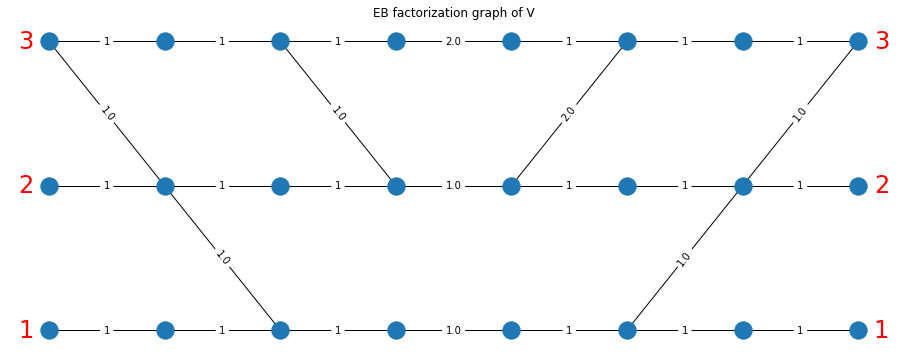

In [2]:

V = np.array([[1,1,1],[1,2,4],[1,3,9]])  # define the matrix V
# ============================================================== 
print("V = \n{}".format(V))
_, ax = plt.subplots(figsize=(16,6))
Lmat, Dmat, Umat, _, valsL, valsU = EB_factorization_ITN( V )
display_EB_factorization( Lmat, Dmat, Umat, valsL, valsU )
draw_EB_factorization_ITN( valsL, np.diagonal(Dmat), valsU, ax )
ax.set_title("EB factorization graph of V")
# show the plot in a pylustrator window

# check factorization
VV = compute_matrix_from_EB_factorization( valsL, np.diagonal(Dmat), valsU )
print("VV (should be equal to V) = \n{}".format(VV))

# compute MC matrix
Q, lp = compute_MC_matrix(V, 2)
print('Q=\n{}'.format(Q))
print('MC order=\n{}'.format(lp+1)) # the indexes in lp starts from 0 

## Few paper examples

In [ ]:

# example 1
n = 3
tol = 1e-10
# ===========
D = np.diag([1,2,3])
A = L(n,3,1)@L(n,2,2)@L(n,3,3)@D@U(n,3,2)@U(n,2,1)@U(n,3,1)
print(A, is_TP(A, tol))

show_mat_latex_format(L(n,3,-3)@L(n,2,-2)@L(n,3,-1)@A)
show_mat_latex_format(D@U(n,3,2)@U(n,2,1)@U(n,3,1))

# the diagram of example 1
savefig_flag1 = 0;
#savefig_name1 = 'EB_diag_exp1.png'
savefig_name1 = 'EB_diag_exp1.eps'
#########################################
plt1, ax1 = plt.subplots(figsize=(16,6))
Lmat1, Dmat1, Umat1, Um1, valsL1, valsU1 = EB_factorization_ITN( A )
display_EB_factorization( Lmat1, Dmat1, Umat1, valsL1, valsU1 )
draw_EB_factorization_ITN(valsL1, np.diagonal(Dmat1), valsU1, ax1)
#ax1.set_title("EB factorization graph of A1")
if savefig_flag1:
    plt1.savefig(savefig_name1, dpi=150)
    print("Figure saved in {}.".format(savefig_name1))


# examples of two matrices with the same s value
# ==============================================
print('\nExample of two matrices with the same s value:')
print('================================================')
n = 4
D1 = np.diag([2,1,3,5])
D2 = np.diag([1,2,3,4])
#A1 = fnt.reduce(np.matmul, [L(n,4,2.5),L(n,3,1.4),L(n,2,4.3),L(n,4,5.1),L(n,3,6.5),D1,U(n,3,2.4),U(n,4,1.2),U(n,2,5.4),U(n,3,4.1),U(n,4,3.5)])
#A2 = fnt.reduce(np.matmul, [L(n,4,5.1),L(n,3,3),L(n,2,2.2),L(n,4,7),L(n,3,2.4),D2,U(n,3,1.2),U(n,4,3.6),U(n,2,2.3),U(n,3,6.1),U(n,4,5.2)])
A1 = fnt.reduce(np.matmul, [L(n,4,2.5),L(n,3,1),L(n,2,4),L(n,4,5.5),L(n,3,6.5),D1,U(n,3,3),U(n,4,2),U(n,2,4),U(n,3,2),U(n,4,3)])
A2 = fnt.reduce(np.matmul, [L(n,4,5),L(n,3,3),L(n,2,2),L(n,4,6),L(n,3,2.5),D2,U(n,3,1.5),U(n,4,3),U(n,2,2),U(n,3,4),U(n,4,3)])

print(is_TP(A1@A2, tol), is_TP(A2@A1, tol), is_TP(A1@A1, tol), is_TP(A2@A2, tol))
print('A1:')
show_mat_latex_format(A1, fmt='2f')
print('A2:')
show_mat_latex_format(A2, fmt='2f')
print('================================================')

# examples of two matrices with the same s_\ell and s_u values
# ============================================================
print('\nExample of two matrices with the same s_ell and s_u value:')
n = 4
D1 = np.diag([2,1,3,5])
D2 = np.diag([1,2,3,4])
A1 = fnt.reduce(np.matmul, [L(n,4,2.5),L(n,3,1),L(n,2,4),L(n,4,5.5),L(n,3,6.5),L(n,4,1),D1,U(n,3,1),U(n,4,2),U(n,2,4),U(n,3,2),U(n,4,3)])
A2 = fnt.reduce(np.matmul, [L(n,4,5),L(n,3,3),L(n,2,2),L(n,4,6),L(n,3,2.5),L(n,4,2),D2,U(n,3,2),U(n,4,1),U(n,2,2),U(n,3,4),U(n,4,3)])

print(is_TP(A1@A2, tol), is_TP(A2@A1, tol), is_TP(A1@A1, tol), is_TP(A2@A2, tol))
print('A1:')
show_mat_latex_format(A1, fmt='2f')
print('A2:')
show_mat_latex_format(A2, fmt='2f')





# example 5
# =============
print('\nExample 5\n')
n=5
tol = 1e-9
#A1=L(n,5,0.5)@L(n,4,0.4)@L(n,3,0.3)@L(n,2,0.2)@L(n,5,0.5)@L(n,4,0.4)@L(n,3,0.3);
#A2=U(n,3,0.3)@U(n,4,0.4)@U(n,5,0.5)@U(n,2,0.2)@U(n,3,0.3)@U(n,4,0.4)@U(n,5,0.5);

#A1=L(n,5,1)@L(n,4,3)@L(n,3,2)@L(n,2,2)@L(n,5,3)@L(n,4,4)@L(n,3,2);
#A2=U(n,3,3)@U(n,4,4)@U(n,5,5)@U(n,2,2)@U(n,3,3)@U(n,4,4)@U(n,5,5);
A1=L(n,5,1)@L(n,4,3)@L(n,3,2)@L(n,2,2)@L(n,5,3)@L(n,4,4)@L(n,3,2);
A2=U(n,3,3)@U(n,4,4)@U(n,5,5)@U(n,2,2)@U(n,3,3)@U(n,4,4)@U(n,5,5);
A = A1@A2;
print(A)
print('A:')
show_mat_latex_format(A, fmt='0f')
#print('A^2:')
#show_mat_latex_format(A@A)
print(is_TP(A@A,tol), is_TP(A@A@A,tol), is_TP(A@A@A@A,tol))



# New example 5 (example of s_\ell and s_u)
# ==========================================
print('\nNew Example 5 (with s_ell and s_u)\n')
n=4
tol = 1e-9
A1 = L(n,4,1)@L(n,3,3)@L(n,2,2)
A2 = U(n,3,1)@U(n,4,2)@U(n,2,1)@U(n,3,2)@U(n,4,1)
A = A1@A2;
print('A:')
show_mat_latex_format(A, fmt='0f')
print(f'A is TP: {is_TP(A, tol)}, A^2 is TP: {is_TP(A@A,tol)}, A^3 is TP: {is_TP(A@A@A,tol)}')
print('A^2=')
show_mat_latex_format(A@A, fmt='0f')
print(f'(A^2)^(3)={compute_MC_matrix(A@A, 3)[0]}')


# example of q_\ell and q_u
# ===========================
print('\nExample with q_ell and q_u\n')
n = 5
A1=L(n,2,2)@L(n,5,3)@L(n,4,4)@L(n,3,2)@L(n,5,2)@L(n,4,1)@L(n,5,2)
A2=U(n,5,1)@U(n,4,2)@U(n,5,3)@U(n,3,3)@U(n,2,2)
A = A1@A2;
print('A:')
show_mat_latex_format(A, fmt='0f')
print('A^2:')
show_mat_latex_format(A@A, fmt='0f')
print(f'A is TP: {is_TP(A, tol)}, A^2 is TP: {is_TP(A@A,tol)}, A^3 is TP: {is_TP(A@A@A,tol)}, A^4 is TP: {is_TP(A@A@A@A,tol)}')


# example of a basic oscillatory (example 2)
# ==========================================
print('\nExample basic oscillatory\n')
n=4
A=L(n,3,1)@L(n,2,2)@L(n,4,3)@U(n,3,4)@U(n,4,5)@U(n,2,6)
print('A=')
show_mat_latex_format(A, fmt='0f')


# example if adding one more term but r(A) deosn't change
# =======================================================
print('\nExample additional terms in prop. 9\n')
n = 3
D = np.array([[1,0,0], [0,1,0], [0,0,1]])
A1 = L(n,2,1)@L(n,3,2)@D@U(n,3,2)@U(n,2,1)
print('A1:')
show_mat_latex_format(A1, fmt='0f')
A2 = A1@U(n,3,4)
print('A2:')
show_mat_latex_format(A2, fmt='0f')

# Last example of adding a term that reduces r from n-1
# =======================================================
print('\nExample for adding a term that reduces r from n-1\n')
n = 4
A = fnt.reduce(np.matmul, [L(n,4,2),L(n,3,1),L(n,2,3),L(n,4,1),L(n,3,2),U(n,2,1),U(n,3,2),U(n,4,3)])
print('A:')
show_mat_latex_format(A, fmt='0f')
print(f'A is TP: {is_TP(A,tol)}, A^2 is TP: {is_TP(A@A, tol)}. A^3 is TP: {is_TP(A@A@A, tol)}')
B = fnt.reduce(np.matmul, [L(n,4,2),L(n,3,1),L(n,2,3),L(n,4,1),L(n,3,2),U(n,4,1),U(n,2,1),U(n,3,2),U(n,4,3)])
print('B:')
show_mat_latex_format(B, fmt='0f')
print(f'B is TP: {is_TP(B,tol)}, B^2 is TP: {is_TP(B@B, tol)}. B^3 is TP: {is_TP(B@B@B, tol)}')
print(compute_MC_matrix(B, 2)[0])

#print(nx.__version__)  # shows networkx version

In [ ]:
# Future research
# =================
n, tol = 4, 1e-9
A1 = fnt.reduce(np.matmul, [L(n,4,2),L(n,3,1),L(n,2,3),U(n,3,1),U(n,4,1),U(n,2,1),U(n,3,2),U(n,4,3)])
A2 = fnt.reduce(np.matmul, [L(n,4,1),L(n,3,3),L(n,2,2),L(n,4,1),L(n,3,2),U(n,2,3),U(n,3,1),U(n,4,2)])
print('A1:')
show_mat_latex_format(A1, fmt='0f')
print('A2:')
show_mat_latex_format(A2, fmt='0f')
print(f'A1^2 is TP: {is_TP(A1@A1,tol)}, A2^2 is TP: {is_TP(A2@A2, tol)}. A1A2 is TP: {is_TP(A1@A2, tol)}, \
A2A1 is TP: {is_TP(A2@A1, tol)}')

Q = A2@A1
print(f'Q^(2) = {compute_MC_matrix(Q, 2)[0]}\nQ2^(3)={compute_MC_matrix(Q, 3)[0]}')

# checking python version
from platform import python_version
print(f'python version={python_version()}')

In [ ]:
# Future research 2
# ==================

'''Trying to deduce r from an arbitrary factorizarion'''
n, tol = 6, 1e-9
#l_order = [ 3, 2,  3,  5,4,  5]
#l_order = [ 3,2,  5,3,  6,5,4,  6,5, 6]
#l_order = [ 2,  7,6,4,3,  7,6,5,4,  7,6,5, 7,6, 7]
l_order = [6,5,4,3,2, 3, 4, 5,6]
D = np.eye(n)
q = 1
u_order = list(reversed(compute_L_indexes(n)))
#print(u_order)
LL = fnt.reduce(np.matmul, [L(n,i,q) for i in l_order])
UU = fnt.reduce(np.matmul, [U(n,i,q) for i in u_order])
A = LL @ D @ UU
for i in range(n-1,0,-1):
    print(f"A^{i} is TP") if is_TP(np.linalg.matrix_power(A,i), tol) else print(f"A^{i} is not TP")


In [ ]:
# the case of Z_5
n, tol = 6, 1e-9
l_order = [6,5,4,3,2]
D = np.eye(n)
q = 1
u_order = list(reversed(compute_L_indexes(n)))
#print(u_order)
LL = fnt.reduce(np.matmul, [L(n,i,q) for i in l_order])
UU = fnt.reduce(np.matmul, [U(n,i,q) for i in u_order])
A = LL @ D @ UU
for i in range(n-1,0,-1):
    print(f"A^{i} is TP") if is_TP(np.linalg.matrix_power(A,i), tol) else print(f"A^{i} is not TP")



In [ ]:
# Examples in the updated version of the paper
# =============================================

''' The case where L = Z_3(1) and U^T=Z_4(1)'''

n, tol = 5, 1e-9
#l_order = [5,4,3,2,5,4,5]
#u_order = [4,5,2,3,4,5] 
l_order = [5,4,2,3,4]
u_order = [2,3,4,5] 
D = np.eye(n)
ql, qu = 1, 2
LL = fnt.reduce(np.matmul, [L(n,i,ql) for i in l_order])
UU = fnt.reduce(np.matmul, [U(n,i,qu) for i in u_order])
A = LL @ D @ UU
print('A=')
#p=3
#np.set_printoptions(precision=4)
#print(f'A^({p})=\n{compute_MC_matrix(A, p)[0]}')
show_mat_latex_format(A, fmt='0f')
print('A^2=')
show_mat_latex_format(A@A, fmt='0f')
print(f'AA^(2) = {compute_MC_matrix(A@A, 2)[0]}\nAA^(3)={compute_MC_matrix(A@A, 3)[0]}\nAA^(4)={compute_MC_matrix(A@A, 4)[0]}')
print('A^3=')
show_mat_latex_format(A@A@A, fmt='0f')
for i in range(n-1,0,-1):
    print(f"A^{i} is TP") if is_TP(np.linalg.matrix_power(A,i), tol) else print(f"A^{i} is not TP")

In [ ]:
# Future research 3
# ==================
n, tol = 6, 1e-9
l_order = [2, 6,5, 4,3, 6,5,4,  6, 5, 6]
D = np.eye(n)
q = 1
u_order = l_order # recall that this is not a real assignment but a reference to the same value of l_order
LL = fnt.reduce(np.matmul, [L(n,i,q) for i in l_order])
UU = fnt.reduce(np.matmul, [U(n,i,q) for i in u_order])
A = LL @ D @ UU
for i in range(n-1,0,-1):
    print(f"A^{i} is TP") if is_TP(np.linalg.matrix_power(A,i), tol) else print(f"A^{i} is not TP")